<a href="https://colab.research.google.com/github/FatihKarabas/AI-WORKS/blob/main/Bandirma_AQIR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S R
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

DATA_SOURCE_MAPPING = 'bandirma-aqi-2021-2024:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F7465914%2F11879576%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20250520%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20250520T091423Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D09dfb840b54ab01a34575ddd9a760792504000f37f38e557bfca945b7367d652f54e140db69a857c99c03e2492fc31834de259c4fd83628404271a220a25799dd2c618a25fca47e0720ad5d0b6257128d286370981f0d344ee9e840b258a9b1265572038375f389e3f172094360e17072f027a641b7624b384d225beff31affcba9163588eba9abccdfea2945f4a2a5ecd8b4198af521810ff2c234498de98f85d9fb33a72140d82f01ac8c375fe19f47fe79bd2ce72b9f7bb4cc816fe1cbdae082983d0664f8f400a61976004bc37d72de3bc42f36a36d35062b0a4954d513e727e68815f78b40d449c630f2d55c76971f7597d9409216fd979c40d94eeb444'

KAGGLE_INPUT_PATH = '/kaggle/input'
KAGGLE_WORKING_PATH = '/kaggle/working'

system(paste0('sudo umount ', '/kaggle/input'))
system(paste0('sudo rmdir ', '/kaggle/input'))
system(paste0('sudo mkdir -p -- ', KAGGLE_INPUT_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_INPUT_PATH), intern=TRUE)
system(
  paste0('sudo ln -sfn ', KAGGLE_INPUT_PATH,' ',file.path('..', 'input')),
  intern=TRUE)

system(paste0('sudo mkdir -p -- ', KAGGLE_WORKING_PATH), intern=TRUE)
system(paste0('sudo chmod 777 ', KAGGLE_WORKING_PATH), intern=TRUE)
system(
  paste0('sudo ln -sfn ', KAGGLE_WORKING_PATH, ' ', file.path('..', 'working')),
  intern=TRUE)

data_source_mappings = strsplit(DATA_SOURCE_MAPPING, ',')[[1]]
for (data_source_mapping in data_source_mappings) {
    path_and_url = strsplit(data_source_mapping, ':')
    directory = path_and_url[[1]][1]
    download_url = URLdecode(path_and_url[[1]][2])
    filename = sub("\\?.+", "", download_url)
    destination_path = file.path(KAGGLE_INPUT_PATH, directory)
    print(paste0('Downloading and uncompressing: ', directory))
    if (endsWith(filename, '.zip')){
      temp = tempfile(fileext = '.zip')
      download.file(download_url, temp)
      unzip(temp, overwrite = TRUE, exdir = destination_path)
      unlink(temp)
    }
    else{
      temp = tempfile(fileext = '.tar')
      download.file(download_url, temp)
      untar(temp, exdir = destination_path)
      unlink(temp)
    }
    print(paste0('Downloaded and uncompressed: ', directory))
}

print(paste0('Data source import complete'))


character(0)

character(0)

character(0)

character(0)

character(0)

character(0)

[1] "Downloading and uncompressing: bandirma-aqi-2021-2024"
[1] "Downloaded and uncompressed: bandirma-aqi-2021-2024"
[1] "Data source import complete"


In [2]:
# Gerekli kütüphaneler
library(readxl)
library(dplyr)
library(ggplot2)
library(tidyr)
library(missForest)
library(imputeTS)
library(mice)
library(patchwork)
library(DescTools)
library(tidyverse)
library(purrr)
library(xgboost)
library(Matrix)
library(knitr)
library(reshape2)
library(zoo)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




ERROR: Error in library(missForest): there is no package called ‘missForest’


In [3]:
data <- read_excel("/kaggle/input/bandirma-aqi-2021-2024/Bandirma_AQ.xlsx")

In [4]:
head(data)

year,month,day,hour,pm10,so2,no2,o3,temp,dwpt,rhum,prcp,wdir,wspd,pres
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021,1,1,0,20.08,6.94,10.22,55.56,11.9,9.5,85,0,180,18.4,1014.5
2021,1,1,1,18.07,8.22,12.64,51.94,11.0,9.1,88,NA,260,14.8,1014.0
2021,1,1,2,26.32,5.63,7.98,66.38,11.0,10.1,94,NA,150,7.6,1014.0
2021,1,1,3,25.14,2.48,4.65,69.10,10.1,9.2,94,NA,170,9.4,1014.6
2021,1,1,4,24.23,2.08,3.49,67.40,11.0,10.1,94,NA,220,7.6,1015.0
2021,1,1,5,24.83,1.89,6.54,59.55,10.0,9.1,94,NA,140,5.4,1015.0


In [5]:
str(data)

tibble [35,064 × 15] (S3: tbl_df/tbl/data.frame)
 $ year : num [1:35064] 2021 2021 2021 2021 2021 ...
 $ month: num [1:35064] 1 1 1 1 1 1 1 1 1 1 ...
 $ day  : num [1:35064] 1 1 1 1 1 1 1 1 1 1 ...
 $ hour : num [1:35064] 0 1 2 3 4 5 6 7 8 9 ...
 $ pm10 : num [1:35064] 20.1 18.1 26.3 25.1 24.2 ...
 $ so2  : num [1:35064] 6.94 8.22 5.63 2.48 2.08 1.89 2.32 2.25 1.72 1.32 ...
 $ no2  : num [1:35064] 10.22 12.64 7.98 4.65 3.49 ...
 $ o3   : num [1:35064] 55.6 51.9 66.4 69.1 67.4 ...
 $ temp : num [1:35064] 11.9 11 11 10.1 11 10 10.7 11 12 12 ...
 $ dwpt : num [1:35064] 9.5 9.1 10.1 9.2 10.1 9.1 9.3 10.1 9 9.6 ...
 $ rhum : num [1:35064] 85 88 94 94 94 94 91 94 82 85 ...
 $ prcp : num [1:35064] 0 NA NA NA NA NA NA NA NA NA ...
 $ wdir : num [1:35064] 180 260 150 170 220 140 170 160 180 180 ...
 $ wspd : num [1:35064] 18.4 14.8 7.6 9.4 7.6 5.4 14.8 20.5 18.4 20.5 ...
 $ pres : num [1:35064] 1014 1014 1014 1015 1015 ...


In [6]:
summary(data)

      year          month             day             hour      
 Min.   :2021   Min.   : 1.000   Min.   : 1.00   Min.   : 0.00  
 1st Qu.:2022   1st Qu.: 4.000   1st Qu.: 8.00   1st Qu.: 5.75  
 Median :2023   Median : 7.000   Median :16.00   Median :11.50  
 Mean   :2023   Mean   : 6.523   Mean   :15.73   Mean   :11.50  
 3rd Qu.:2023   3rd Qu.:10.000   3rd Qu.:23.00   3rd Qu.:17.25  
 Max.   :2024   Max.   :12.000   Max.   :31.00   Max.   :23.00  
                                                                
      pm10             so2               no2               o3        
 Min.   :  0.31   Min.   :  0.000   Min.   :  0.38   Min.   :  1.28  
 1st Qu.: 26.27   1st Qu.:  3.830   1st Qu.: 16.96   1st Qu.: 31.28  
 Median : 37.62   Median :  6.230   Median : 27.27   Median : 53.39  
 Mean   : 43.26   Mean   :  8.259   Mean   : 31.75   Mean   : 54.21  
 3rd Qu.: 53.81   3rd Qu.: 10.460   3rd Qu.: 41.70   3rd Qu.: 75.26  
 Max.   :320.89   Max.   :209.860   Max.   :178.03   Max.   

In [8]:
dim(data)

[1] 35064    15

In [9]:
colSums(is.na(data))

year month   day  hour  pm10   so2   no2    o3  temp  dwpt  rhum  prcp  wdir 
    0     0     0     0  2698  1124  1119 12180     0     0     0   286    29 
 wspd  pres 
    0   162

In [10]:
colMeans(is.na(data)) * 100

year       month         day        hour        pm10         so2 
 0.00000000  0.00000000  0.00000000  0.00000000  7.69450148  3.20556696 
        no2          o3        temp        dwpt        rhum        prcp 
 3.19130732 34.73648186  0.00000000  0.00000000  0.00000000  0.81565138 
       wdir        wspd        pres 
 0.08270591  0.00000000  0.46201232

Eksik Değeri Olan Sütunlar İçin Sayı ve Yüzde Tablosu

In [11]:
eksik_ozet <- data.frame(
  Degisken = names(data),
  Eksik_Sayi = colSums(is.na(data)),
  Eksik_Yuzde = round(colMeans(is.na(data)) * 100, 2)
)
eksik_ozet <- eksik_ozet[eksik_ozet$Eksik_Sayi > 0, ]
print(eksik_ozet)

     Degisken Eksik_Sayi Eksik_Yuzde
pm10     pm10       2698        7.69
so2       so2       1124        3.21
no2       no2       1119        3.19
o3         o3      12180       34.74
prcp     prcp        286        0.82
wdir     wdir         29        0.08
pres     pres        162        0.46


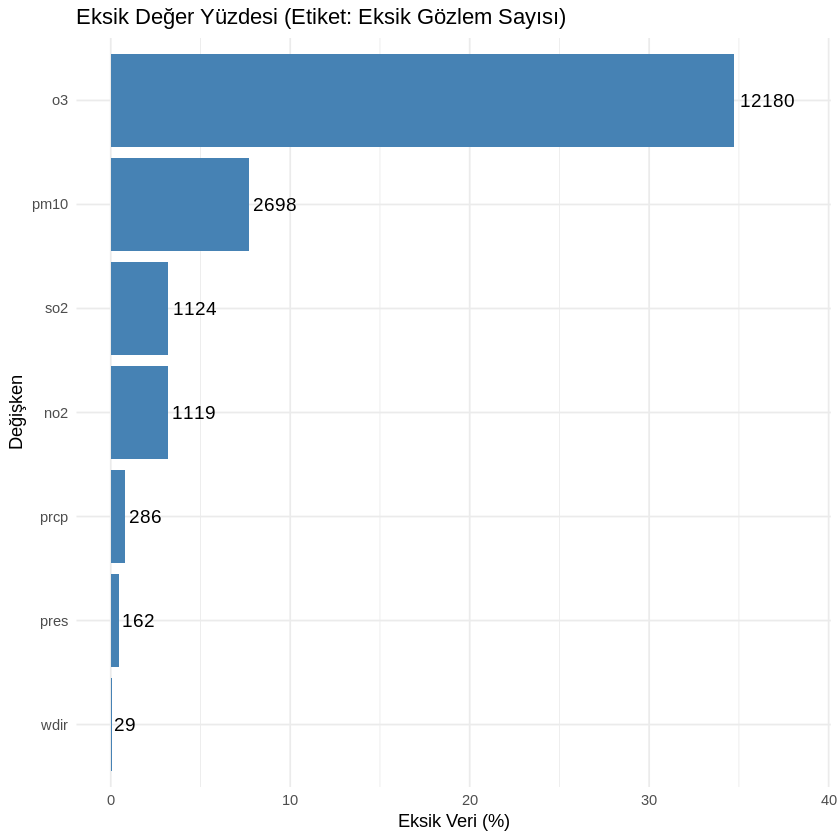

In [12]:
ggplot(eksik_ozet, aes(x = reorder(Degisken, Eksik_Yuzde), y = Eksik_Yuzde)) +
  geom_col(fill = "steelblue") +
  geom_text(aes(label = Eksik_Sayi),
            hjust = -0.1, size = 4) +
  coord_flip() +
  labs(title = "Eksik Değer Yüzdesi (Etiket: Eksik Gözlem Sayısı)",
       x = "Değişken", y = "Eksik Veri (%)") +
  theme_minimal() +
  ylim(0, max(eksik_ozet$Eksik_Yuzde) * 1.1)

options(repr.plot.width = 12, repr.plot.height = 8)

In [13]:
data$datetime <- as.POSIXct(sprintf("%04d-%02d-%02d %02d:00:00",
                                    data$year, data$month, data$day, data$hour),
                            format = "%Y-%m-%d %H:%M:%S")

In [14]:
Eksik gözlemleri mevsimsellik temelinde zaman serisi üzerinde analiz etmek,
eksik verilerin belirli mevsimlerde (ilkbahar, yaz, sonbahar, kış)
sistematik bir şekilde tekrar edip etmediğini anlamak açısından oldukça değerlidir.

ERROR: Error in parse(text = input): <text>:1:7: unexpected symbol
1: Eksik gözlemleri
          ^


Mevsimleri oluşturma

In [15]:
data <- data %>%
  mutate(
    month = as.numeric(format(datetime, "%m")),
    hour = as.numeric(format(datetime, "%H")),
    season = case_when(
      month %in% c(12, 1, 2)  ~ "Kış",
      month %in% c(3, 4, 5)   ~ "İlkbahar",
      month %in% c(6, 7, 8)   ~ "Yaz",
      month %in% c(9, 10, 11) ~ "Sonbahar"
    )
  )

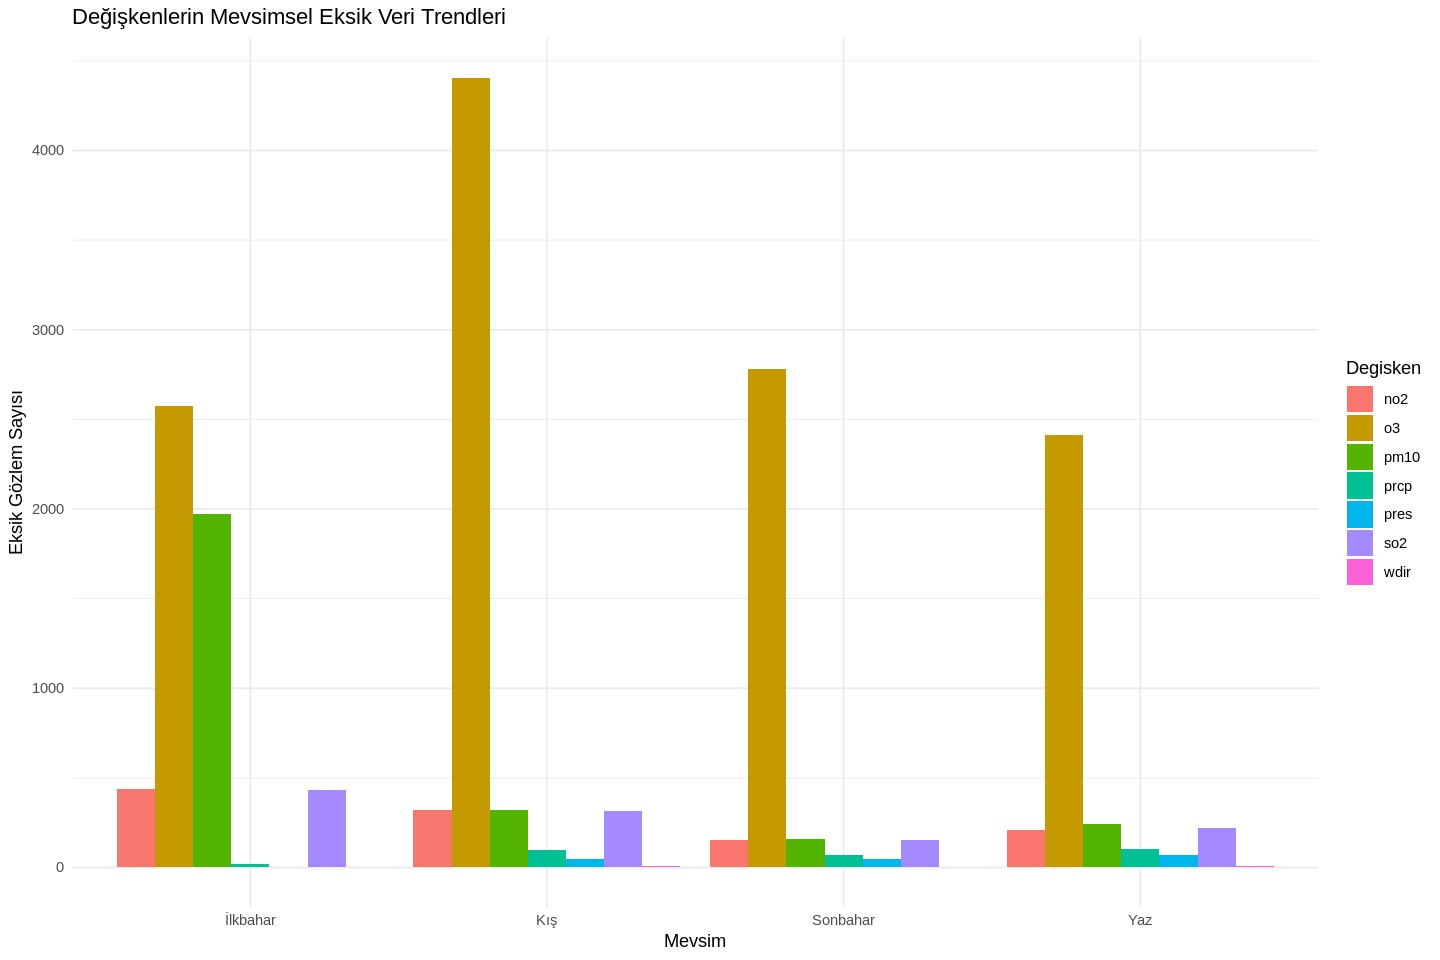

In [16]:
# Eksik veri sütunları
eksik_sezon <- data %>%
  mutate(
    across(c(pm10, so2, no2, o3, prcp, wdir, pres), ~ is.na(.), .names = "na_{.col}")
  ) %>%
  group_by(season) %>%
  summarise(across(starts_with("na_"), sum, .names = "sum_{.col}"), .groups = "drop") %>%
  pivot_longer(cols = starts_with("sum_"), names_to = "Degisken", values_to = "Eksik_Sayi") %>%
  mutate(Degisken = gsub("sum_na_", "", Degisken))

library(ggplot2)

ggplot(eksik_sezon, aes(x = season, y = Eksik_Sayi, fill = Degisken)) +
  geom_col(position = "dodge") +
  labs(title = "Değişkenlerin Mevsimsel Eksik Veri Trendleri",
       x = "Mevsim", y = "Eksik Gözlem Sayısı") +
  theme_minimal()


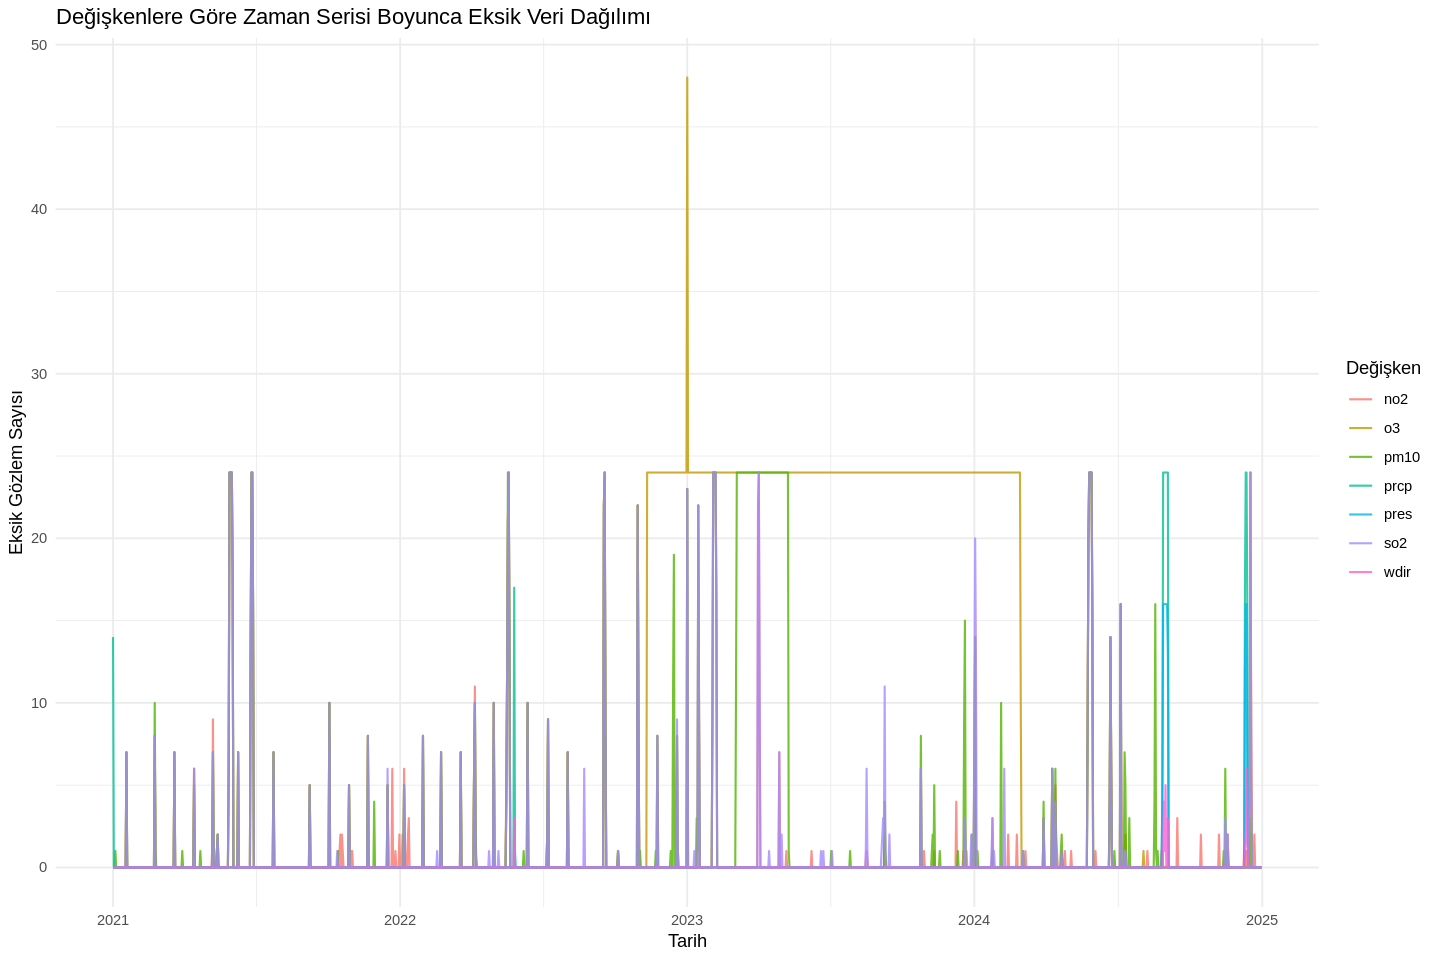

In [17]:
# Günlük tarih
data$day_date <- as.Date(data$datetime)

# Eksik gözlem bilgilerini oluştur
data_na_flags <- data %>%
  mutate(across(c(pm10, so2, no2, o3, prcp, wdir, pres),
                ~ is.na(.), .names = "na_{.col}"))

#### Günlük Eksik Gözlem Sayısını Hesapla

eksik_ts <- data_na_flags %>%
  group_by(day_date) %>%
  summarise(across(starts_with("na_"), sum), .groups = "drop") %>%
  pivot_longer(cols = starts_with("na_"),
               names_to = "Degisken", values_to = "Eksik_Sayi") %>%
  mutate(Degisken = gsub("na_", "", Degisken))

######  Zaman Serisi Grafiğini Çiz
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(eksik_ts, aes(x = day_date, y = Eksik_Sayi, color = Degisken)) +
  geom_line(alpha = 0.8, linewidth = 0.6) +
  labs(title = "Değişkenlere Göre Zaman Serisi Boyunca Eksik Veri Dağılımı",
       x = "Tarih", y = "Eksik Gözlem Sayısı", color = "Değişken") +
  theme_minimal()

In [19]:
options(repr.plot.width = 12, repr.plot.height = 8)
g1 <- ggplot(eksik_ts, aes(x = day_date, y = Eksik_Sayi)) +
  geom_line(color = "steelblue") +
  facet_wrap(~Degisken, scales = "free_y", ncol = 2) +
  labs(title = "Eksik Veri Zaman Serileri",
       x = "Tarih", y = "Eksik Gözlem Sayısı") +
  theme_minimal()

# Açıklama paneli (y = 0.5, vjust = 0.5 ile ortalanır)
g2 <- ggplot() +
  theme_void() +
  annotate("text", x = 1, y = 0.5, hjust = 0, vjust = 0.5, size = 3.5,
           label = paste(
             "🔁 Mevsimsel desen var mı? → O3 ve PM10 için belirgin\n",
             "🛑 Uzun süreli eksiklik? → O3: 2022 sonu - 2023 ortası\n",
             "📉 Azalan eksiklik? → WDIR, PRES\n",
             "📈 Belirli dönemde eksiklik? → NO2, SO2, PM10", sep = ""
           ))

# Yükseklik oranını artır (açıklama için daha fazla yer)
g1 / g2 + plot_layout(heights = c(4, 1.3))

ERROR: Error in g1/g2: non-numeric argument to binary operator


# mice() (Multivariate Imputation by Chained Equations)

eksik verilerin çok değişkenli istatistiksel modeller kullanılarak
doldurulmasını sağlayan güçlü bir R paketidir.
Temel yaklaşımı, her bir eksik değişkeni diğer değişkenler yardımıyla
ayrı ayrı tahmin etmeye dayanır.
Zincirleme regresyon modeli (chained equations) ile çalışır.
Eksik veriye sahip her değişken için özel bir tahmin modeli kurar.
Eksiklik oranı yüksek verilerde daha güvenilir sonuçlar üretir.
Mevsim, saat gibi zamansal bileşenler dahil edilerek tahmin gücü artırılabilir.

#######  Model verisini oluşturma

pm10, so2, o3, prcp, no2 gibi negatif değer alamaz değişkenleri,
mice() kullanarak yalnızca pozitif değerlerle tahmin etmek.
ÖZEL TAHMİN FONKSİYONU: norm.positive

In [ ]:
library(mice)
veri_mice <- data %>%
  select(pm10, so2, no2, o3, prcp, wdir, pres, temp, rhum, wspd, hour, month, season)

veri_mice$season <- as.factor(veri_mice$season)

### Eksik verileri mice() ile tamamla
imp_all <- mice(veri_mice, m = 1, method = "norm.predict", seed = 42)

##### Tamamlanan verileri ana veri setine aktar

tamamlanan <- complete(imp_all)

data$pm10_imputed <- tamamlanan$pm10
data$so2_imputed  <- tamamlanan$so2
data$no2_imputed  <- tamamlanan$no2
data$o3_imputed   <- tamamlanan$o3
data$prcp_imputed <- tamamlanan$prcp
data$wdir_imputed <- tamamlanan$wdir
data$pres_imputed <- tamamlanan$pres


 iter imp variable
  1   1  pm10  so2  no2  o3  prcp  wdir  pres
  2   1  pm10  so2  no2  o3  prcp  wdir  pres
  3   1  pm10  so2  no2  o3  prcp  wdir  pres
  4   1  pm10  so2  no2  o3  prcp  wdir  pres
  5   1  pm10  so2  no2  o3  prcp  wdir  pres


**Yeni veri setini data_r olarak tanımla******

In [ ]:
# Yeni veri setini tanımla
data_r <- data %>%
  transmute(
    datetime = datetime,  # zaman bilgisi
    year = year,
    month = month,
    day = day,
    hour = hour,
    season = season,

    # MICE ile tamamlanmış değişkenler
    pm10 = pm10_imputed,
    so2 = so2_imputed,
    no2 = no2_imputed,
    o3 = o3_imputed,
    prcp = prcp_imputed,
    wdir = wdir_imputed,
    pres = pres_imputed,

    # Eksiksiz olan diğer değişkenler (örn: meteoroloji)
    temp = temp,
    rhum = rhum,
    wspd = wspd
  )


In [ ]:
colSums(is.na(data_r))
head(data_r, 5)
str(data_r)
summary(data_r)
dim(data_r)

datetime     year    month      day     hour   season     pm10      so2 
       0        0        0        0        0        0        0        0 
     no2       o3     prcp     wdir     pres     temp     rhum     wspd 
       0        0        0        0        0        0        0        0

datetime,year,month,day,hour,season,pm10,so2,no2,o3,prcp,wdir,pres,temp,rhum,wspd
<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2021-01-01 00:00:00,2021,1,1,0,Kış,20.08,6.94,10.22,55.56,0.0000000,180,1014.5,11.9,85,18.4
2021-01-01 01:00:00,2021,1,1,1,Kış,18.07,8.22,12.64,51.94,0.2246197,260,1014.0,11.0,88,14.8
2021-01-01 02:00:00,2021,1,1,2,Kış,26.32,5.63,7.98,66.38,0.1779871,150,1014.0,11.0,94,7.6
2021-01-01 03:00:00,2021,1,1,3,Kış,25.14,2.48,4.65,69.10,0.1840040,170,1014.6,10.1,94,9.4
2021-01-01 04:00:00,2021,1,1,4,Kış,24.23,2.08,3.49,67.40,0.1709517,220,1015.0,11.0,94,7.6


tibble [35,064 × 16] (S3: tbl_df/tbl/data.frame)
 $ datetime: POSIXct[1:35064], format: "2021-01-01 00:00:00" "2021-01-01 01:00:00" ...
 $ year    : num [1:35064] 2021 2021 2021 2021 2021 ...
 $ month   : num [1:35064] 1 1 1 1 1 1 1 1 1 1 ...
 $ day     : num [1:35064] 1 1 1 1 1 1 1 1 1 1 ...
 $ hour    : num [1:35064] 0 1 2 3 4 5 6 7 8 9 ...
 $ season  : chr [1:35064] "Kış" "Kış" "Kış" "Kış" ...
 $ pm10    : num [1:35064] 20.1 18.1 26.3 25.1 24.2 ...
 $ so2     : num [1:35064] 6.94 8.22 5.63 2.48 2.08 1.89 2.32 2.25 1.72 1.32 ...
 $ no2     : num [1:35064] 10.22 12.64 7.98 4.65 3.49 ...
 $ o3      : num [1:35064] 55.6 51.9 66.4 69.1 67.4 ...
 $ prcp    : num [1:35064] 0 0.225 0.178 0.184 0.171 ...
 $ wdir    : num [1:35064] 180 260 150 170 220 140 170 160 180 180 ...
 $ pres    : num [1:35064] 1014 1014 1014 1015 1015 ...
 $ temp    : num [1:35064] 11.9 11 11 10.1 11 10 10.7 11 12 12 ...
 $ rhum    : num [1:35064] 85 88 94 94 94 94 91 94 82 85 ...
 $ wspd    : num [1:35064] 18.4 14.8 

    datetime                           year          month       
 Min.   :2021-01-01 00:00:00.00   Min.   :2021   Min.   : 1.000  
 1st Qu.:2022-01-01 05:45:00.00   1st Qu.:2022   1st Qu.: 4.000  
 Median :2023-01-01 05:30:00.00   Median :2023   Median : 7.000  
 Mean   :2023-01-01 05:30:14.77   Mean   :2023   Mean   : 6.523  
 3rd Qu.:2023-12-31 17:15:00.00   3rd Qu.:2023   3rd Qu.:10.000  
 Max.   :2024-12-31 23:00:00.00   Max.   :2024   Max.   :12.000  
      day             hour          season               pm10        
 Min.   : 1.00   Min.   : 0.00   Length:35064       Min.   : -2.257  
 1st Qu.: 8.00   1st Qu.: 5.75   Class :character   1st Qu.: 27.058  
 Median :16.00   Median :11.50   Mode  :character   Median : 38.790  
 Mean   :15.73   Mean   :11.50                      Mean   : 43.690  
 3rd Qu.:23.00   3rd Qu.:17.25                      3rd Qu.: 54.220  
 Max.   :31.00   Max.   :23.00                      Max.   :320.890  
      so2               no2               o3    

[1] 35064    16

In [ ]:

data_r[names(data_r) != "temp"] <- lapply(data_r[names(data_r) != "temp"], function(x) {
  if (is.numeric(x)) ifelse(x < 0, 0, x) else x
})

"temp" değişkeni hariç negatif değer olmadığını kontrol et

In [ ]:
summary(data_r)
sapply(data_r, function(x) any(x < 0, na.rm = TRUE))

    datetime                           year          month       
 Min.   :2021-01-01 00:00:00.00   Min.   :2021   Min.   : 1.000  
 1st Qu.:2022-01-01 05:45:00.00   1st Qu.:2022   1st Qu.: 4.000  
 Median :2023-01-01 05:30:00.00   Median :2023   Median : 7.000  
 Mean   :2023-01-01 05:30:14.77   Mean   :2023   Mean   : 6.523  
 3rd Qu.:2023-12-31 17:15:00.00   3rd Qu.:2023   3rd Qu.:10.000  
 Max.   :2024-12-31 23:00:00.00   Max.   :2024   Max.   :12.000  
      day             hour          season               pm10       
 Min.   : 1.00   Min.   : 0.00   Length:35064       Min.   :  0.00  
 1st Qu.: 8.00   1st Qu.: 5.75   Class :character   1st Qu.: 27.06  
 Median :16.00   Median :11.50   Mode  :character   Median : 38.79  
 Mean   :15.73   Mean   :11.50                      Mean   : 43.69  
 3rd Qu.:23.00   3rd Qu.:17.25                      3rd Qu.: 54.22  
 Max.   :31.00   Max.   :23.00                      Max.   :320.89  
      so2               no2               o3           

datetime     year    month      day     hour   season     pm10      so2 
   FALSE    FALSE    FALSE    FALSE    FALSE    FALSE    FALSE    FALSE 
     no2       o3     prcp     wdir     pres     temp     rhum     wspd 
   FALSE    FALSE    FALSE    FALSE    FALSE     TRUE    FALSE    FALSE


**Aykırı Deger Analizi**

In [ ]:

# Tüm sayısal sütunları seç
sayisal_deg <- data_r %>% select(where(is.numeric)) %>% names()

# Z-score hesapla ve aykırıları işaretle
for (var in sayisal_deg) {
  data_r[[paste0(var, "_z")]] <- scale(data_r[[var]])
  data_r[[paste0(var, "_z_outlier")]] <- abs(data_r[[paste0(var, "_z")]]) > 3
}

# Z-score tabanlı aykırı özet:
zscore_ozet <- data.frame(
  Degisken = gsub("_z_outlier", "", grep("_z_outlier$", names(data_r), value = TRUE)),
  Aykiri_Sayi = sapply(grep("_z_outlier$", names(data_r), value = TRUE),
                       function(col) sum(data_r[[col]], na.rm = TRUE)),
  Toplam = nrow(data_r)
) %>%
  mutate(Aykiri_Yuzde = round(100 * Aykiri_Sayi / Toplam, 2)) %>%
  filter(Aykiri_Sayi > 0)  # 🔍 0 olanları çıkar

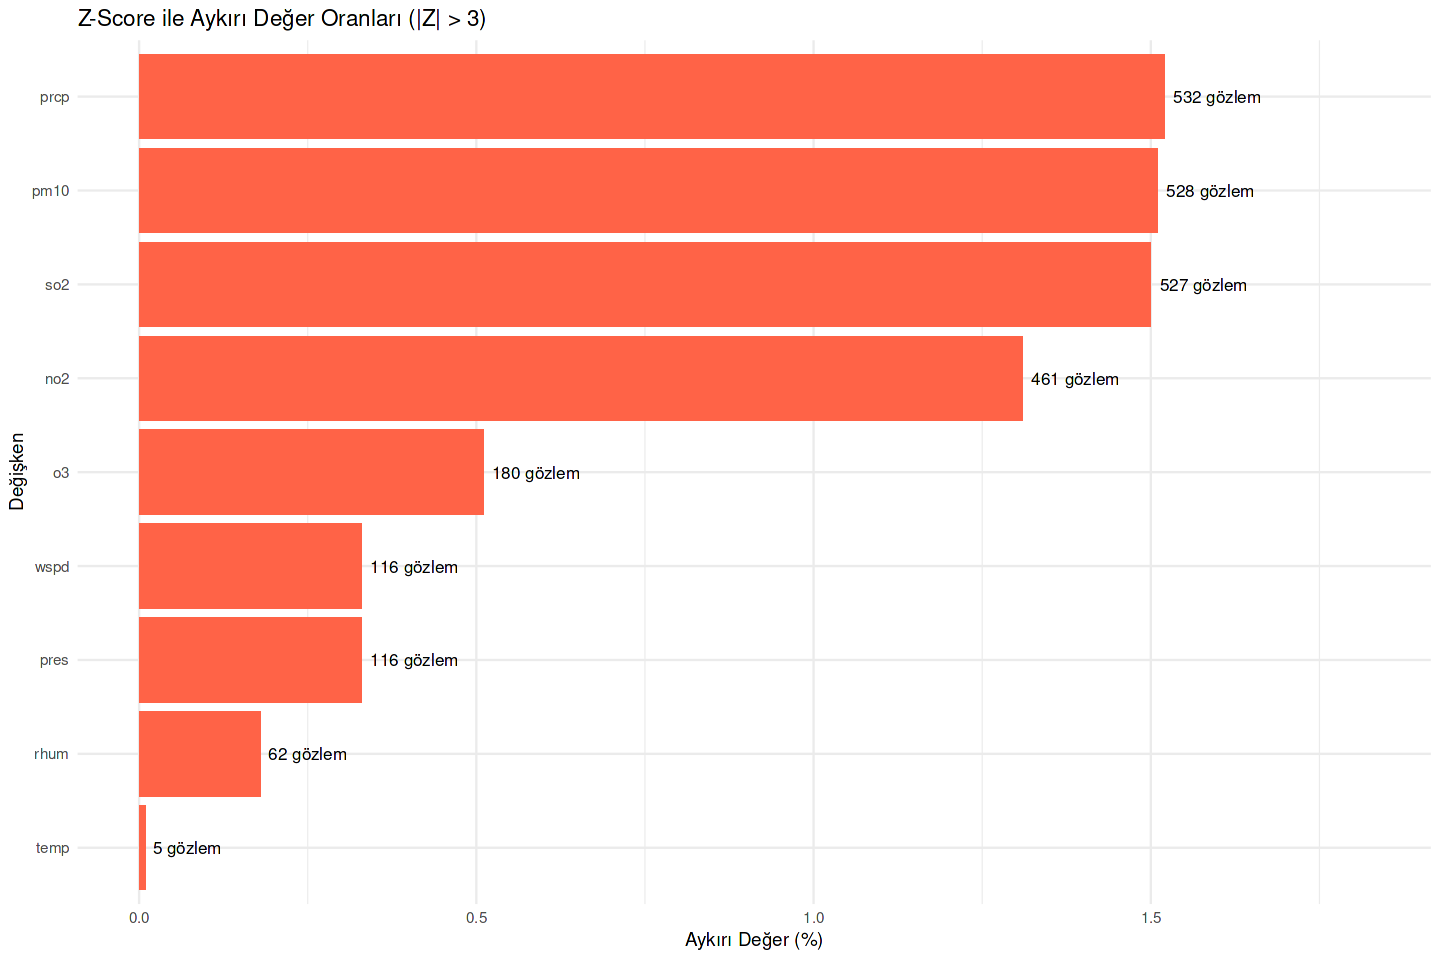

In [ ]:
# Barplot
# Yükseklik ve genişlik ayarı (örneğin: 12 x 8 inç)
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(zscore_ozet, aes(x = reorder(Degisken, Aykiri_Yuzde), y = Aykiri_Yuzde)) +
  geom_col(fill = "tomato") +
  geom_text(aes(label = paste0(Aykiri_Sayi, " gözlem")),
            hjust = -0.1, size = 3.5) +
  coord_flip() +
  labs(title = "Z-Score ile Aykırı Değer Oranları (|Z| > 3)",
       x = "Değişken", y = "Aykırı Değer (%)") +
  theme_minimal() +
  ylim(0, max(zscore_ozet$Aykiri_Yuzde) * 1.2)


**IQR**********

In [ ]:
# İstenen değişkenler
tum_degiskenler <- c("pm10", "so2", "no2", "o3", "temp", "dwpt",
                     "rhum", "prcp", "wdir", "wspd", "pres")

# Sadece veri setinde mevcut olanları al
gecerli_degiskenler <- tum_degiskenler[tum_degiskenler %in% names(data_r)]
print(gecerli_degiskenler)

for (deg in gecerli_degiskenler) {
  Q1 <- quantile(data_r[[deg]], 0.25, na.rm = TRUE)
  Q3 <- quantile(data_r[[deg]], 0.75, na.rm = TRUE)
  IQR_val <- Q3 - Q1
  alt <- Q1 - 1.5 * IQR_val
  ust <- Q3 + 1.5 * IQR_val
  data_r[[paste0(deg, "_iqr_outlier")]] <- data_r[[deg]] < alt | data_r[[deg]] > ust
}

iqr_cols <- paste0(gecerli_degiskenler, "_iqr_outlier")

iqr_ozet <- data.frame(
  Degisken = gecerli_degiskenler,
  Aykiri_Sayi = sapply(iqr_cols, function(col) sum(data_r[[col]], na.rm = TRUE)),
  Toplam = nrow(data_r)
) %>%
  mutate(Aykiri_Yuzde = round(100 * Aykiri_Sayi / Toplam, 2)) %>%
  filter(Aykiri_Sayi > 0)

 [1] "pm10" "so2"  "no2"  "o3"   "temp" "rhum" "prcp" "wdir" "wspd" "pres"


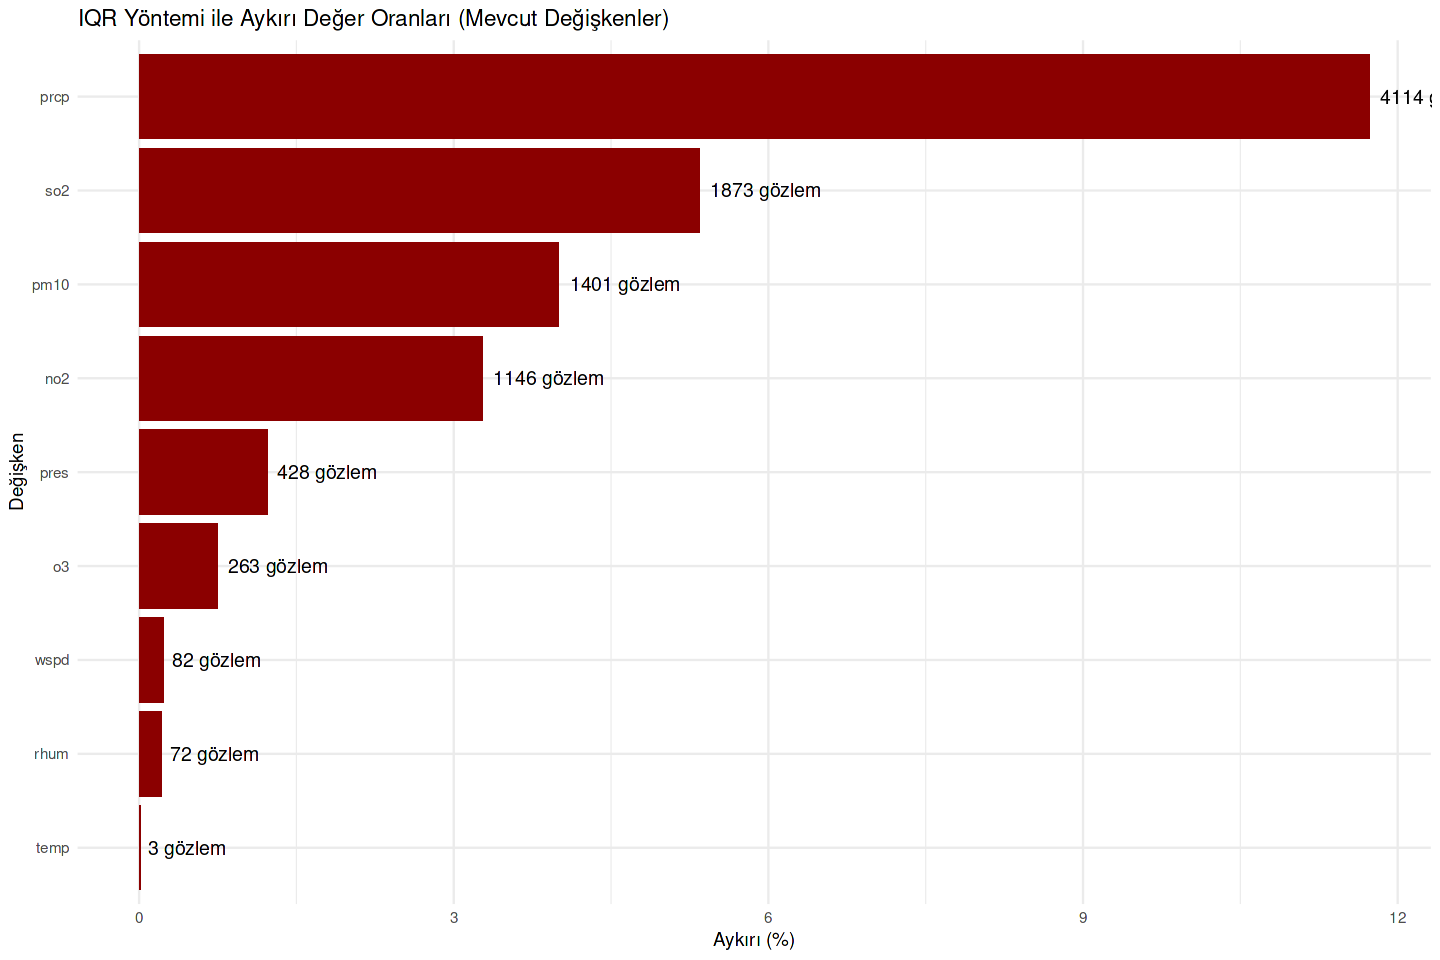

In [ ]:
# Yükseklik ve genişlik ayarı (örneğin: 12 x 8 inç)
options(repr.plot.width = 12, repr.plot.height = 8)
ggplot(iqr_ozet, aes(x = reorder(Degisken, Aykiri_Yuzde), y = Aykiri_Yuzde)) +
  geom_col(fill = "darkred") +
  geom_text(aes(label = paste0(Aykiri_Sayi, " gözlem")),
            hjust = -0.1, size = 4) +
  coord_flip() +
  labs(title = "IQR Yöntemi ile Aykırı Değer Oranları (Mevcut Değişkenler)",
       x = "Değişken", y = "Aykırı (%)") +
  theme_minimal()

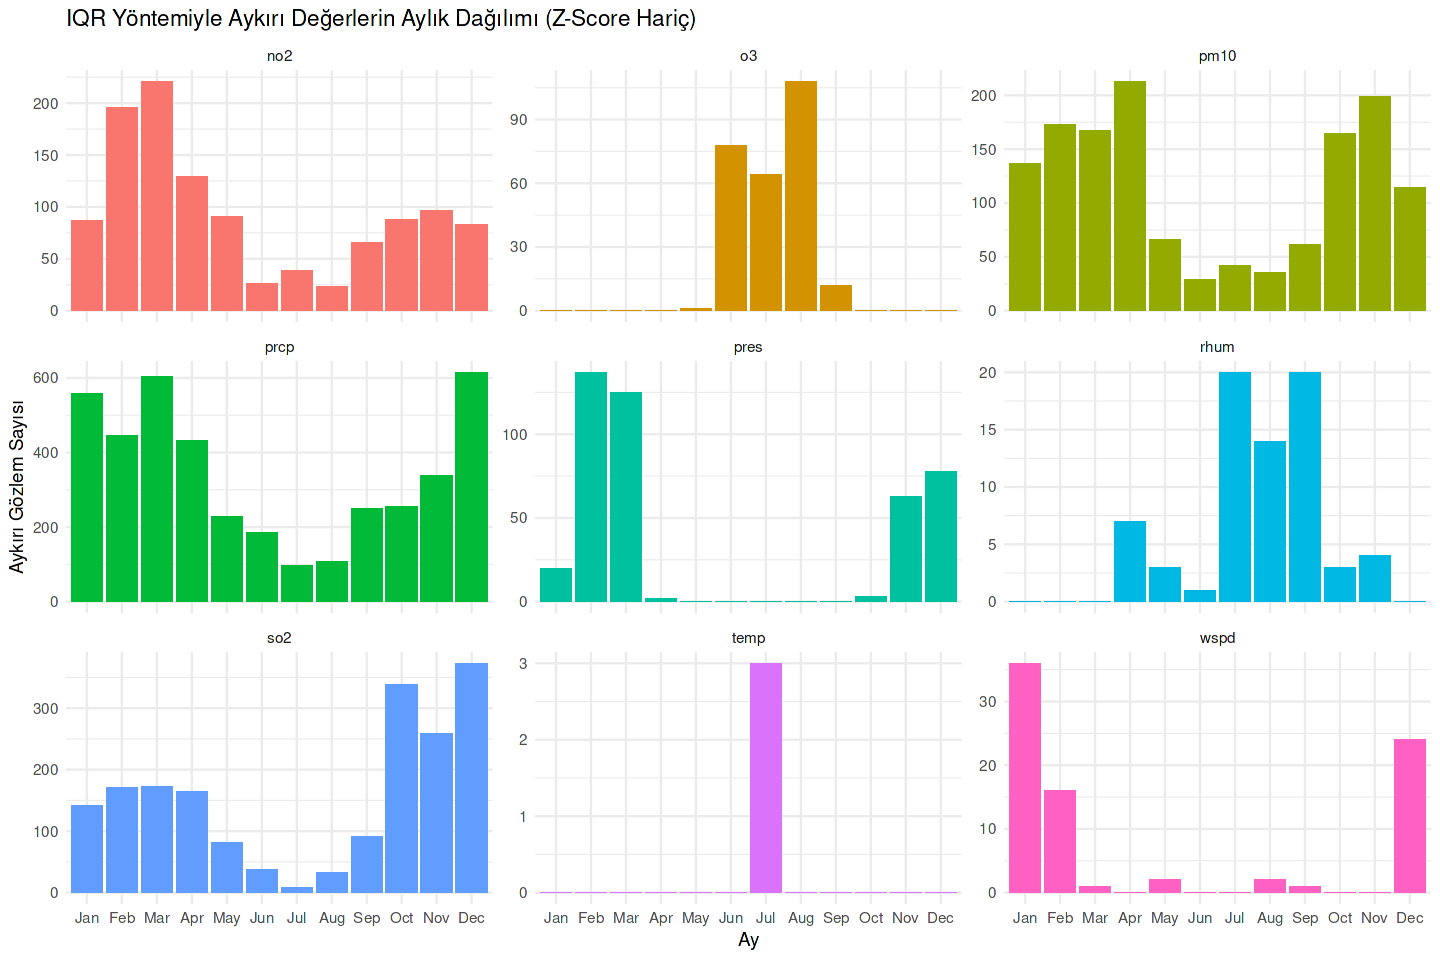

In [ ]:
######## IQR  aykırı değerlerin aylara göre dağılımı

library(dplyr)
library(ggplot2)

# 🔍 1. Sadece _iqr_outlier ile biten ve _z içermeyen sütunları seç
iqr_cols <- names(data_r)
iqr_outlier_cols <- iqr_cols[grepl("_iqr_outlier$", iqr_cols) & !grepl("_z", iqr_cols)]

# 🔎 2. En az bir aykırı gözlem içerenleri filtrele
iqr_outlier_cols_aktif <- iqr_outlier_cols[sapply(iqr_outlier_cols, function(col) {
  sum(data_r[[col]], na.rm = TRUE) > 0
})]

# Aylık aykırı sayısını hesapla
iqr_aylik_ozet <- lapply(iqr_outlier_cols_aktif, function(col) {
  degisken_adi <- gsub("_iqr_outlier", "", col)
  data_r %>%
    mutate(month = factor(month, levels = 1:12, labels = month.abb)) %>%
    group_by(month) %>%
    summarise(Aykiri_Sayi = sum(.data[[col]], na.rm = TRUE), .groups = "drop") %>%
    mutate(Degisken = degisken_adi)
}) %>%
  bind_rows()
# Yükseklik ve genişlik ayarı (örneğin: 12 x 8 inç)
options(repr.plot.width = 12, repr.plot.height = 8)

ggplot(iqr_aylik_ozet, aes(x = month, y = Aykiri_Sayi, fill = Degisken)) +
  geom_col(show.legend = FALSE) +
  facet_wrap(~Degisken, scales = "free_y") +
  labs(title = "IQR Yöntemiyle Aykırı Değerlerin Aylık Dağılımı (Z-Score Hariç)",
       x = "Ay", y = "Aykırı Gözlem Sayısı") +
  theme_minimal()

**AQI HESAPLAMA**#

Türkiye Ulusal Hava Kalitesi İndeksi’ni oluştururken, US-EPA Hava Kalitesi İndeksi’ni ulusal mevzuat ve sınır değerleriyle uyumlu hale getirmiştir.

İndeksi belirleyen hava kirletici maddeler,

partikül madde (PM10), (24 saatlik ortalama)

karbon monoksit (CO), (8 saatlik ortalama)(Bandırma verileri bulunamadı)

azot dioksit (NO2), (1 saatlik ortalama)

kükürt dioksit (SO2) (1 saatlik ortalama)

ozon (O3)(8 saatlik ortalama)

-PM2.5 için sınır değerinin henüz bulunmamasıdır.

Söz parametreler www.havaizleme.gov.tr adresinden anlık olarak takip edilebilmektedir

![image.png](attachment:152d5c6d-5f1c-4423-a67c-65bcea9da89b.png)![image.png]

In [ ]:
#  Ulusal Türkiye HKİ Kesme Noktalarının Tanımlanması

# Türkiye Ulusal HKİ Kesme Noktaları
hki_araliklari <- list(
  pm10 = data.frame(
    I_lo = c(0, 51, 101, 151, 201, 301),
    I_hi = c(50, 100, 150, 200, 300, 500),
    BP_lo = c(0, 51, 101, 151, 201, 301),
    BP_hi = c(50, 100, 150, 200, 300, 500)
  ),
  so2 = data.frame(
    I_lo = c(0, 51, 101, 151, 201, 301),
    I_hi = c(50, 100, 150, 200, 300, 500),
    BP_lo = c(0, 51, 101, 151, 201, 301),
    BP_hi = c(50, 100, 150, 200, 300, 500)
  ),
  no2 = data.frame(
    I_lo = c(0, 51, 101, 151, 201, 301),
    I_hi = c(50, 100, 150, 200, 300, 500),
    BP_lo = c(0, 101, 201, 400, 800, 1600),
    BP_hi = c(100, 200, 399, 799, 1599, 2000)
  ),
  o3 = data.frame(
    I_lo = c(0, 51, 101, 151, 201, 301),
    I_hi = c(50, 100, 150, 200, 300, 500),
    BP_lo = c(0, 121, 181, 241, 401, 801),
    BP_hi = c(120, 180, 240, 400, 800, 1000)
  )
)

![image.png](attachment:99dab227-ed81-481a-a7ef-04ab72a81035.png)![image.png]

In [ ]:
# HKİ Hesaplama Fonksiyonu

hesapla_hki <- function(c, pollutant) {
  if (is.na(c)) return(NA)  # Eksik gözlemler için
  aralik <- hki_araliklari[[pollutant]]
  for (i in 1:nrow(aralik)) {
    if (c >= aralik$BP_lo[i] && c <= aralik$BP_hi[i]) {
      return(
        (aralik$I_hi[i] - aralik$I_lo[i]) / (aralik$BP_hi[i] - aralik$BP_lo[i]) *
          (c - aralik$BP_lo[i]) + aralik$I_lo[i]
      )
    }
  }
  return(NA)  # Eğer hiçbir aralığa girmiyorsa
}

#  Ortalama Süreler ve HKİ Sütunlarının Oluşturulması

library(dplyr)
library(zoo)  # rollmean fonksiyonu için

data_hki <- data_r %>%
  arrange(datetime) %>%
  mutate(
    pm10_avg = zoo::rollmean(pm10, k = 24, fill = NA, align = "right"),
    o3_avg   = zoo::rollmean(o3,   k = 8,  fill = NA, align = "right"),
    so2_avg  = so2,
    no2_avg  = no2
  ) %>%
  rowwise() %>%
  mutate(
    pm10_AQI = hesapla_hki(pm10_avg, "pm10"),
    o3_AQI   = hesapla_hki(o3_avg, "o3"),
    so2_AQI  = hesapla_hki(so2_avg, "so2"),
    no2_AQI  = hesapla_hki(no2_avg, "no2"),
    gen_AQI  = max(c(pm10_AQI, o3_AQI, so2_AQI, no2_AQI), na.rm = TRUE)
  ) %>%
  ungroup()


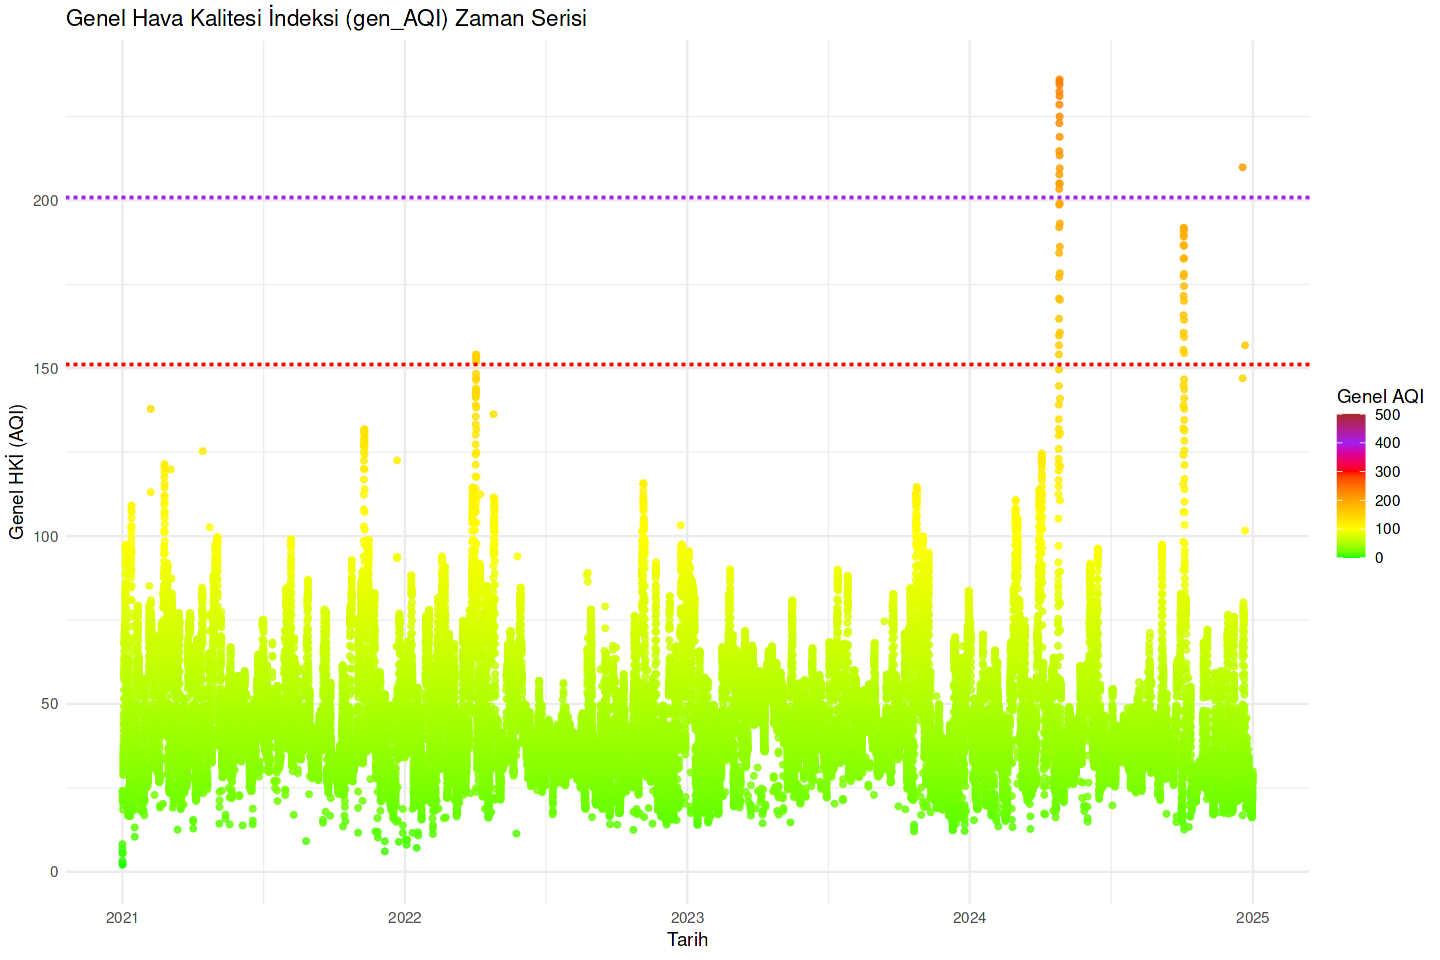

In [ ]:
library(ggplot2)

ggplot(data_hki, aes(x = datetime, y = gen_AQI, color = gen_AQI)) +
  geom_point(size = 1.2, alpha = 0.8) +
  scale_color_gradientn(
    colors = c("green", "yellow", "orange", "red", "purple", "brown"),
    limits = c(0, 500),
    name = "Genel AQI"
  ) +
  geom_hline(yintercept = 151, color = "red", linetype = "dashed", linewidth = 0.8) +
  geom_hline(yintercept = 201, color = "purple", linetype = "dashed", linewidth = 0.8) +
  labs(
    title = "Genel Hava Kalitesi İndeksi (gen_AQI) Zaman Serisi",
    x = "Tarih",
    y = "Genel HKİ (AQI)"
  ) +
  theme_minimal()

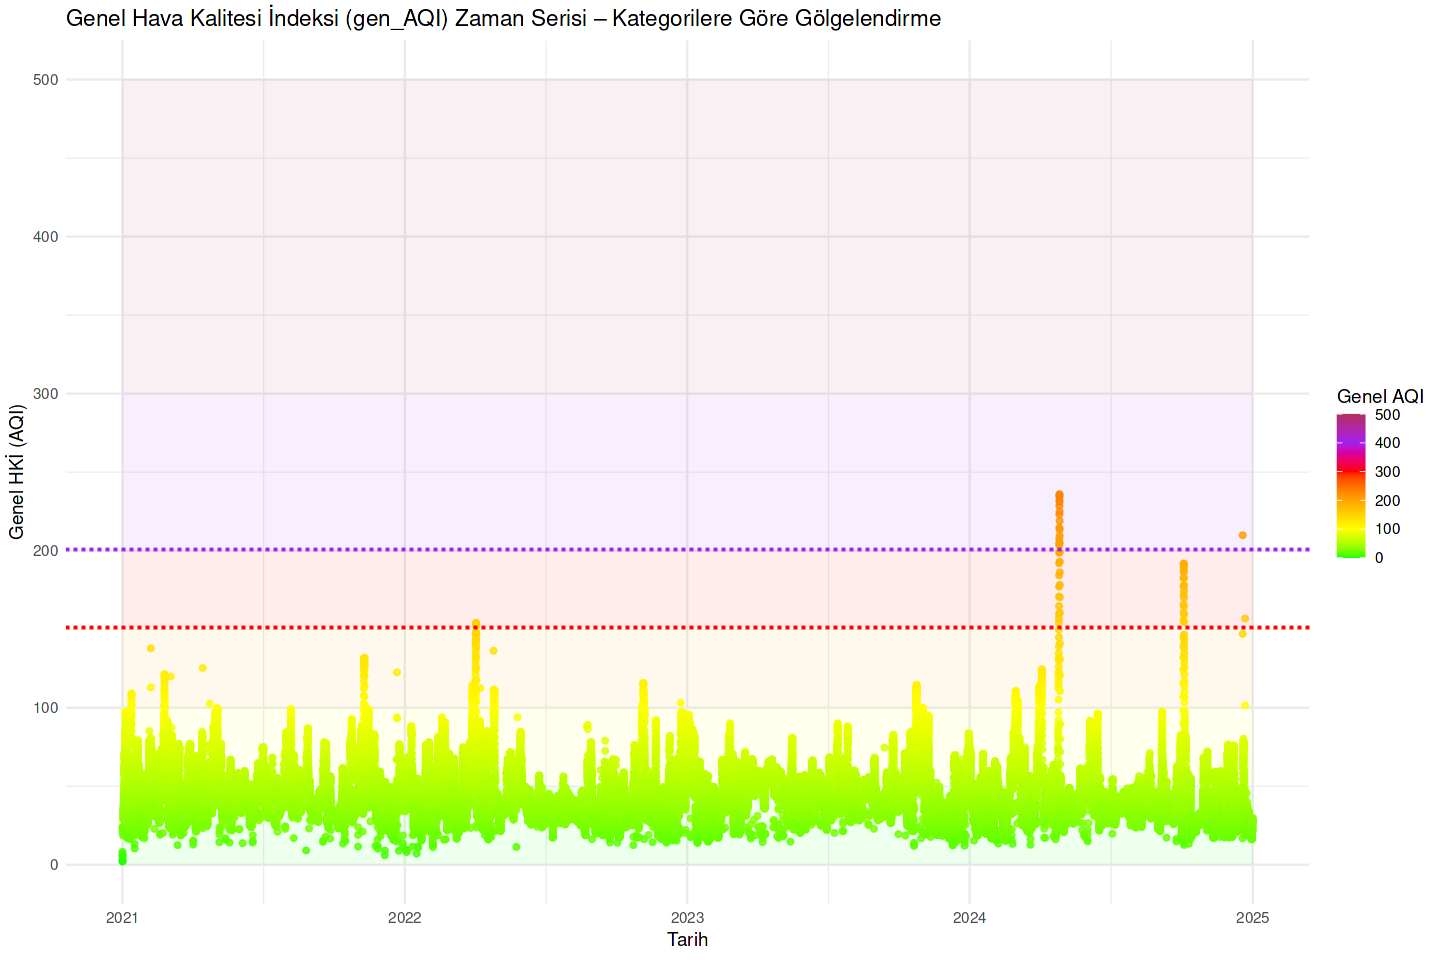

In [ ]:
library(ggplot2)

ggplot(data_hki, aes(x = datetime, y = gen_AQI)) +

  # Gölgelendirme katmanları (her kategori için geom_rect)
  annotate("rect", xmin = min(data_hki$datetime), xmax = max(data_hki$datetime),
           ymin = 0, ymax = 50, fill = "green", alpha = 0.07) +
  annotate("rect", xmin = min(data_hki$datetime), xmax = max(data_hki$datetime),
           ymin = 51, ymax = 100, fill = "yellow", alpha = 0.07) +
  annotate("rect", xmin = min(data_hki$datetime), xmax = max(data_hki$datetime),
           ymin = 101, ymax = 150, fill = "orange", alpha = 0.07) +
  annotate("rect", xmin = min(data_hki$datetime), xmax = max(data_hki$datetime),
           ymin = 151, ymax = 200, fill = "red", alpha = 0.07) +
  annotate("rect", xmin = min(data_hki$datetime), xmax = max(data_hki$datetime),
           ymin = 201, ymax = 300, fill = "purple", alpha = 0.07) +
  annotate("rect", xmin = min(data_hki$datetime), xmax = max(data_hki$datetime),
           ymin = 301, ymax = 500, fill = "maroon", alpha = 0.07) +

  # Nokta grafiği
  geom_point(aes(color = gen_AQI), size = 1.2, alpha = 0.8) +

  # Renk skalası
  scale_color_gradientn(
    colors = c("green", "yellow", "orange", "red", "purple", "maroon"),
    limits = c(0, 500),
    name = "Genel AQI"
  ) +

  # Eşik çizgileri
  geom_hline(yintercept = 151, color = "red", linetype = "dashed", linewidth = 0.8) +
  geom_hline(yintercept = 201, color = "purple", linetype = "dashed", linewidth = 0.8) +

  # Etiketler
  labs(
    title = "Genel Hava Kalitesi İndeksi (gen_AQI) Zaman Serisi – Kategorilere Göre Gölgelendirme",
    x = "Tarih",
    y = "Genel HKİ (AQI)"
  ) +
  theme_minimal()

Hangi Kirletici Kaç Kere En Yüksek Olmuş?

In [ ]:
data_hki <- data_hki %>%
  mutate(
    max_kirletici = pmap_chr(
      list(pm10_AQI, so2_AQI, no2_AQI, o3_AQI),
      function(pm10, so2, no2, o3) {
        kirleticiler <- c(pm10 = pm10, so2 = so2, no2 = no2, o3 = o3)
        if (all(is.na(kirleticiler))) return(NA_character_)
        names(kirleticiler)[which.max(kirleticiler)]
      }
    )
  )
table(data_hki$max_kirletici)


  no2    o3  pm10   so2 
 1540  6109 27181   234 

**Genel AQI Degerine En Fazla Etki Eden Kirletici**

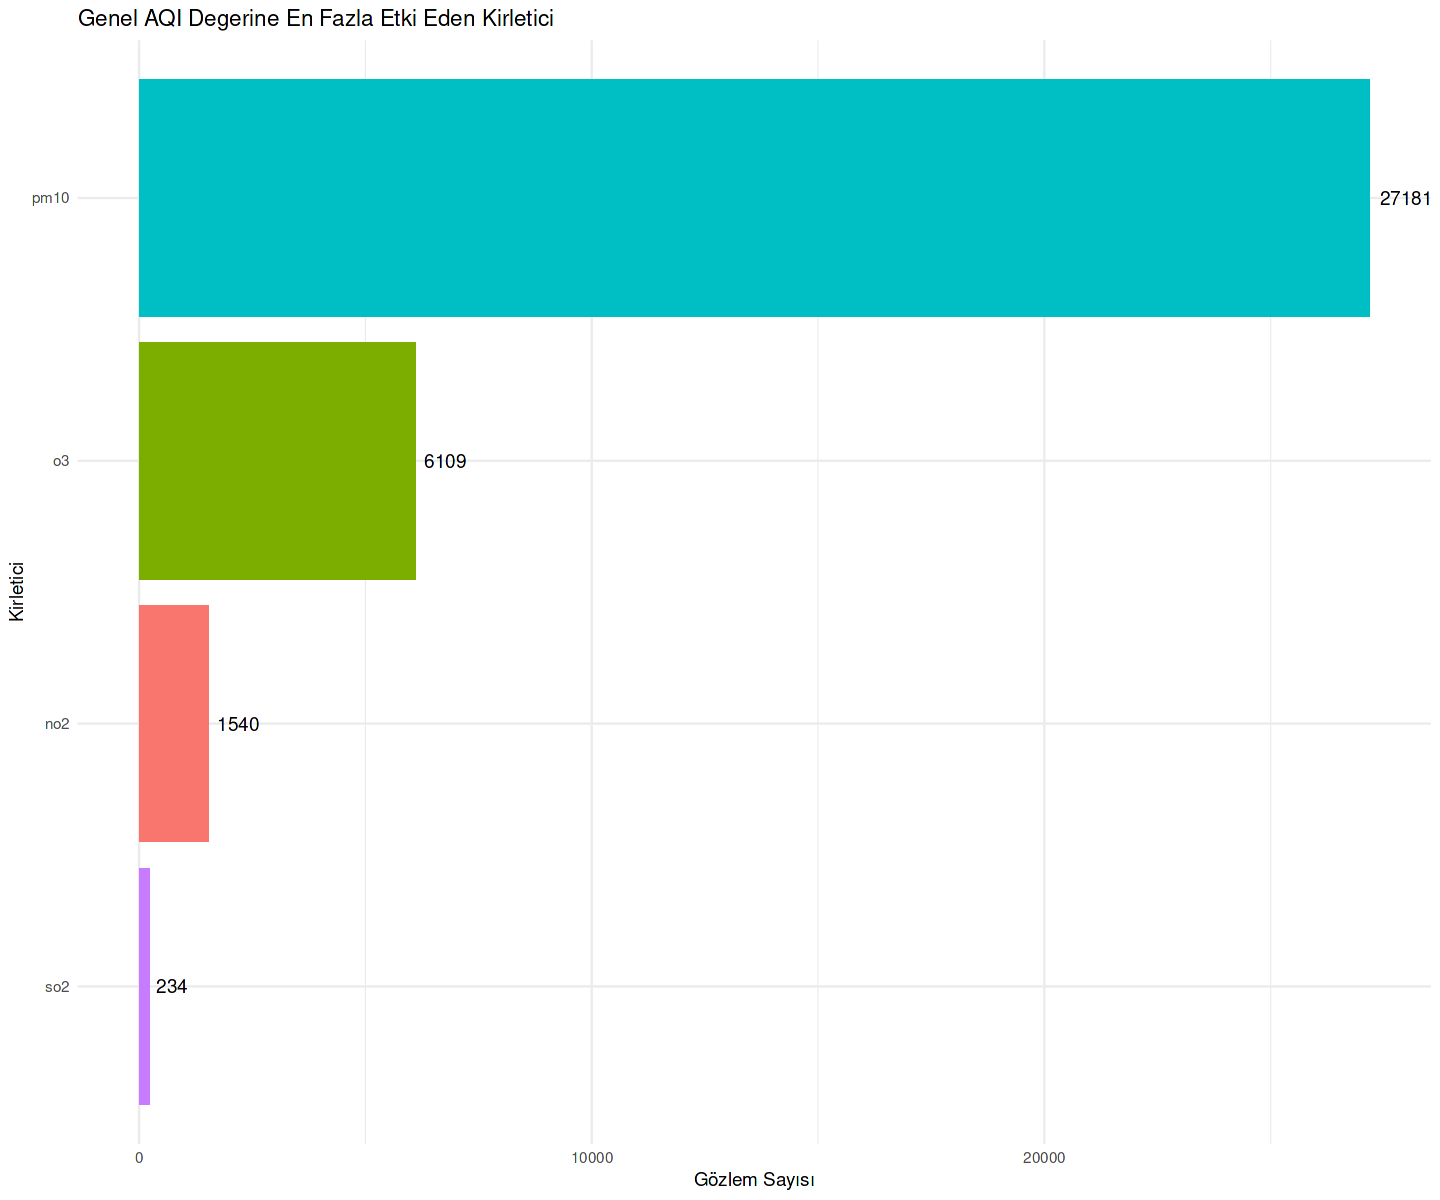

In [ ]:
library(ggplot2)
options(repr.plot.width = 12, repr.plot.height = 10)
data_hki %>%
  filter(!is.na(max_kirletici)) %>%
  count(max_kirletici) %>%
  ggplot(aes(x = reorder(max_kirletici, n), y = n, fill = max_kirletici)) +
  geom_col(show.legend = FALSE) +
  geom_text(aes(label = n), hjust = -0.2) +
  coord_flip() +
  labs(
    title = "Genel AQI Degerine En Fazla Etki Eden Kirletici",
    x = "Kirletici", y = "Gözlem Sayısı"
  ) +
  theme_minimal()

In [ ]:
model_df <- data_hki %>%
  select(gen_AQI, temp, rhum, wspd, pres) %>%
  filter(complete.cases(.))


model <- lm(gen_AQI ~ temp + rhum + wspd + pres, data = model_df)
summary(model)


Call:
lm(formula = gen_AQI ~ temp + rhum + wspd + pres, data = model_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-46.748 -11.701  -3.397   7.971 186.490 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 245.59193   18.49929  13.276   <2e-16 ***
temp          0.04318    0.01719   2.513    0.012 *  
rhum         -0.09103    0.00722 -12.608   <2e-16 ***
wspd         -0.46499    0.00886 -52.483   <2e-16 ***
pres         -0.18419    0.01795 -10.262   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 17.94 on 35059 degrees of freedom
Multiple R-squared:  0.08031,	Adjusted R-squared:  0.08021 
F-statistic: 765.4 on 4 and 35059 DF,  p-value: < 2.2e-16


**XGBoost **

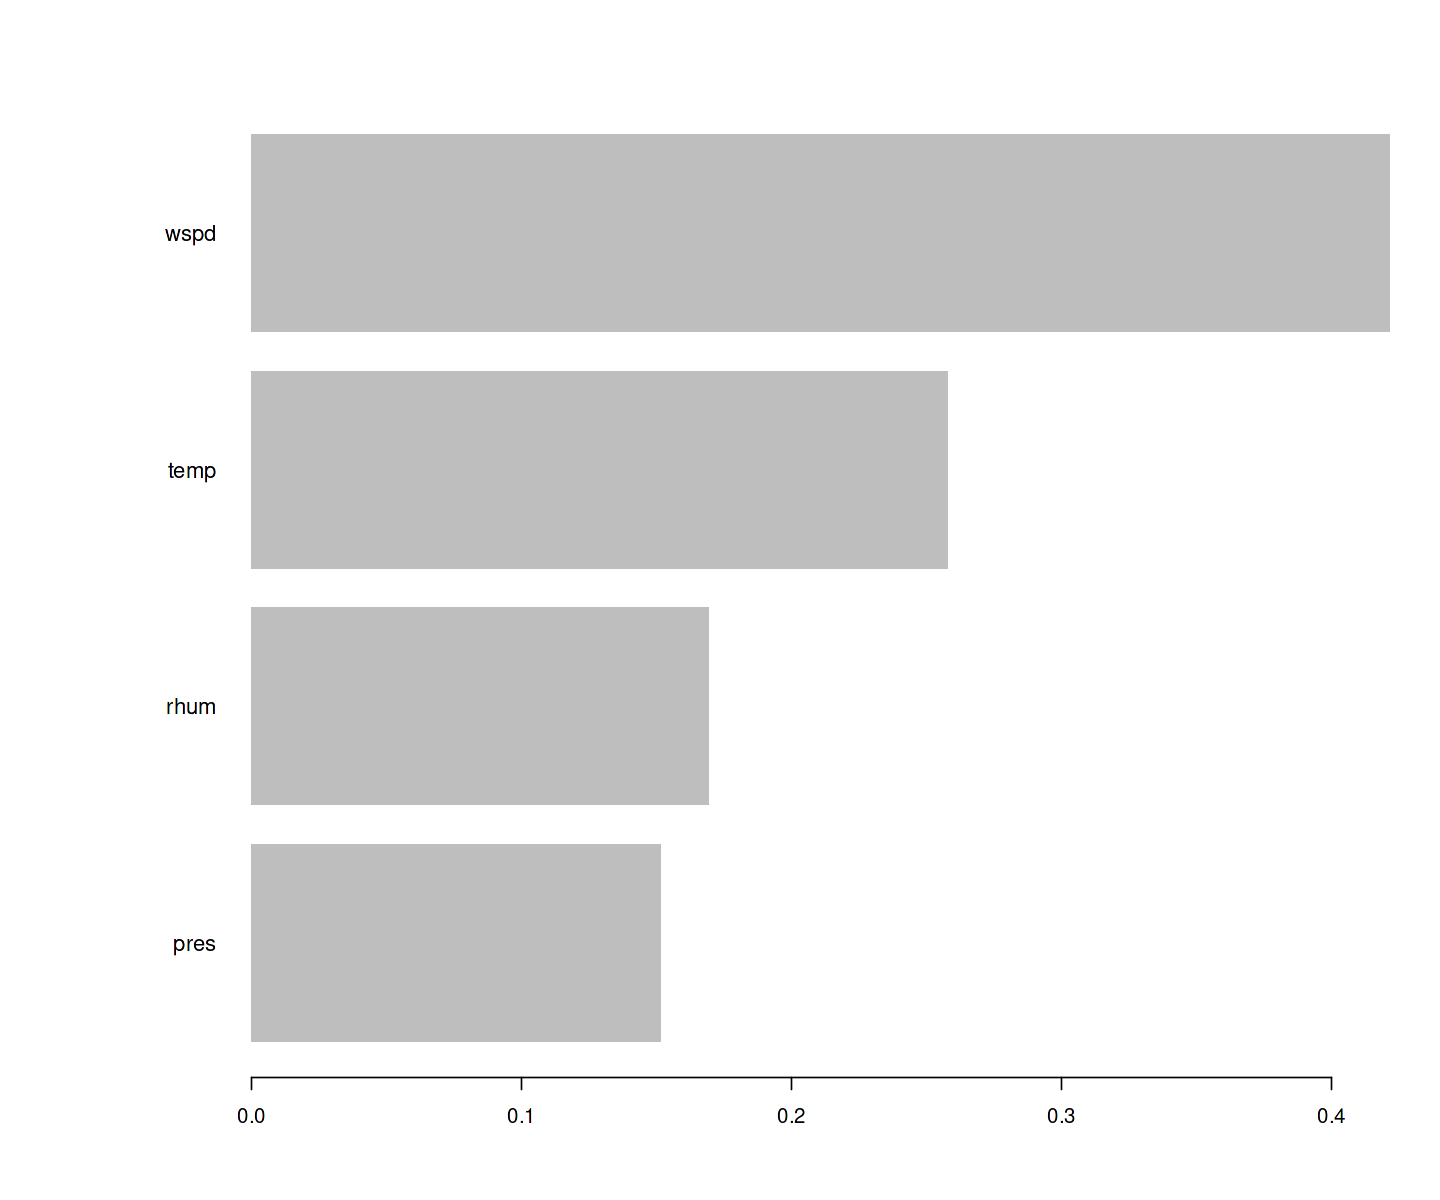

In [ ]:
library(xgboost)

# Gerekli değişkenler ve eksik veri temizliği
xgb_df <- data_hki %>%
  select(gen_AQI, temp, rhum, wspd, pres) %>%
  filter(complete.cases(.))

# Bağımlı ve bağımsız değişkenleri ayır
y <- xgb_df$gen_AQI
x <- xgb_df %>% select(-gen_AQI) %>% as.matrix()

dtrain <- xgb.DMatrix(data = x, label = y)

set.seed(42)
xgb_model <- xgboost(
  data = dtrain,
  objective = "reg:squarederror",
  nrounds = 100,
  eta = 0.1,
  max_depth = 4,
  verbose = 0
)

importance <- xgb.importance(model = xgb_model)
xgb.plot.importance(importance_matrix = importance)


In [ ]:
karsilastirma <- data.frame(
  Ozellik = c("Ruzgar (wspd)", "Sicaklik (temp)", "Nem (rhum)", "Basinc (pres)"),
  Regresyon_Modeli = c("En guclu negatif etki",
                       "Anlamli ama kucuk etki",
                       "Anlamli negatif etki",
                       "Anlamli negatif etki"),
  XGBoost = c("En yuksek onem",
              "Orta duzey katkı",
              "Orta duzey katkı",
              "Gorece daha az etkili")
)

library(knitr)
kable(karsilastirma, format = "markdown", caption = "Karsilastirmali Yorum: XGBoost vs Regresyon")




Table: Karsilastirmali Yorum: XGBoost vs Regresyon

|Ozellik         |Regresyon_Modeli       |XGBoost               |
|:---------------|:----------------------|:---------------------|
|Ruzgar (wspd)   |En guclu negatif etki  |En yuksek onem        |
|Sicaklik (temp) |Anlamli ama kucuk etki |Orta duzey katkı      |
|Nem (rhum)      |Anlamli negatif etki   |Orta duzey katkı      |
|Basinc (pres)   |Anlamli negatif etki   |Gorece daha az etkili |

pm10_AQI hedef değişkeni ile meteorolojik değişkenler (temp, rhum, wspd, pres)
arasındaki ilişkiyi çoklu doğrusal regresyon (multiple linear regression)
kullanarak adım adım analiz edeceğimiz

In [ ]:
regresyon_veri <- data_r %>%
  select(pm10_AQI, temp, rhum, wspd, pres) %>%
  na.omit()  # Eksik değer varsa kaldır

# Çoklu doğrusal regresyon modeli
model_pm10 <- lm(pm10_AQI ~ temp + rhum + wspd + pres, data = regresyon_veri)

# Özet sonuçları
summary(model_pm10)

# Diyagnostik grafikler
par(mfrow = c(2, 2))
plot(model_pm10)

ERROR: [1m[33mError[39m in `select()`:[22m
[33m![39m Can't select columns that don't exist.
[31m✖[39m Column `pm10_AQI` doesn't exist.
